In [4]:
%idle_timeout 20
%worker_type Standard
%number_of_workers 2

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.6 
Current idle_timeout is None minutes.
idle_timeout has been set to 20 minutes.
Previous worker type: None
Setting new worker type to: Standard
Previous number of workers: None
Setting new number of workers to: 2


In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("muted")
from pyspark.sql.functions import col, sum
from pyspark.sql import functions as F
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, IntegerType, StringType, NumericType

In [2]:
spark = SparkSession.builder.appName("Amazon Product Data Cleaning").getOrCreate()

# 1. Load data

### Dataset Information

- **asin**: Product ID from Amazon (type: `str`)
- **title**: Title of the product (type: `str`)
- **imgUrl**: URL of the product image (type: `str`)
- **productURL**: URL of the product (type: `str`)
- **stars**: Product rating. `0` if no ratings were found (type: `float`)
- **reviews**: Number of reviews. `0` if no reviews were found (type: `int`)
- **price**: Buy now price of the product in USD. `0` if unavailable (type: `float`)
- **listPrice**: Original price before discount in USD. `0` if no discount (type: `float`)
- **category_id**: Category ID. Refer to `amazon_categories.csv` for actual category names (type: `int`)
- **isBestSeller**: Whether the product had the Amazon BestSeller status (type: `bool`)

Note: For the **category_id** column, please refer to the `amazon_categories.csv` file to find the corresponding category names.

In [3]:
bucket_name = 'amazon-product-dataset-2024'
categories_file_path = 's3://{}/amazon_categories.csv'.format(bucket_name)
products_file_path = 's3://{}/amazon_products.csv'.format(bucket_name)

In [4]:
categories = spark.read.csv(categories_file_path, header=True, inferSchema=True)
categories.show(5)

+---+--------------------+
| id|       category_name|
+---+--------------------+
|  1|Beading & Jewelry...|
|  2|   Fabric Decorating|
|  3|Knitting & Croche...|
|  4|Printmaking Supplies|
|  5|Scrapbooking & St...|
+---+--------------------+
only showing top 5 rows


In [5]:
products_df = spark.read.csv(products_file_path, header=True, inferSchema=True)
products_df.show(5)

+----------+--------------------+--------------------+--------------------+-----+-------+------+---------+-----------+------------+-----------------+
|      asin|               title|              imgUrl|          productURL|stars|reviews| price|listPrice|category_id|isBestSeller|boughtInLastMonth|
+----------+--------------------+--------------------+--------------------+-----+-------+------+---------+-----------+------------+-----------------+
|B014TMV5YE|Sion Softside Exp...|https://m.media-a...|https://www.amazo...|  4.5|      0|139.99|      0.0|        104|       False|             2000|
|B07GDLCQXV|Luggage Sets Expa...|https://m.media-a...|https://www.amazo...|  4.5|      0|169.99|   209.99|        104|       False|             1000|
|B07XSCCZYG|Platinum Elite So...|https://m.media-a...|https://www.amazo...|  4.6|      0|365.49|   429.99|        104|       False|              300|
|B08MVFKGJM|Freeform Hardside...|https://m.media-a...|https://www.amazo...|  4.6|      0|291.59|   3

In [6]:
# Check schema
print("Categories DataFrame Schema:")
categories.printSchema()

print("Products DataFrame Schema:")
products_df.printSchema()

# We note that we will need to change data type of columns.

Categories DataFrame Schema:
root
 |-- id: integer (nullable = true)
 |-- category_name: string (nullable = true)

Products DataFrame Schema:
root
 |-- asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- imgUrl: string (nullable = true)
 |-- productURL: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- listPrice: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- isBestSeller: string (nullable = true)
 |-- boughtInLastMonth: string (nullable = true)


In [7]:
# View summary statistics
print("Summary Statistics for 'categories':")
categories.describe().show()

print("Summary Statistics for 'products_df':")
products_df.describe().show()

# We note that many columns seem to have incorrect data recorded such as string in numeric columns and vice versa

Summary Statistics for 'categories':
+-------+-----------------+--------------------+
|summary|               id|       category_name|
+-------+-----------------+--------------------+
|  count|              248|                 248|
|   mean|          133.875|                null|
| stddev|77.13244104485779|                null|
|    min|                1|Abrasive & Finish...|
|    max|              270|eBook Readers & A...|
+-------+-----------------+--------------------+

Summary Statistics for 'products_df':
+-------+--------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|summary|                asin|               title|            imgUrl|            productURL|               stars|             reviews|               price|           listPrice|         category_id|       isBestSeller|   boughtInLastMonth|
+--

In [ ]:
# Drop irrelevant rows (image and product URL)

In [8]:
products = products_df.drop("imgUrl", "productURL")

In [9]:
products.show(5)

+----------+--------------------+-----+-------+------+---------+-----------+------------+-----------------+
|      asin|               title|stars|reviews| price|listPrice|category_id|isBestSeller|boughtInLastMonth|
+----------+--------------------+-----+-------+------+---------+-----------+------------+-----------------+
|B014TMV5YE|Sion Softside Exp...|  4.5|      0|139.99|      0.0|        104|       False|             2000|
|B07GDLCQXV|Luggage Sets Expa...|  4.5|      0|169.99|   209.99|        104|       False|             1000|
|B07XSCCZYG|Platinum Elite So...|  4.6|      0|365.49|   429.99|        104|       False|              300|
|B08MVFKGJM|Freeform Hardside...|  4.6|      0|291.59|   354.37|        104|       False|              400|
|B01DJLKZBA|Winfield 2 Hardsi...|  4.5|      0|174.99|   309.99|        104|       False|              400|
+----------+--------------------+-----+-------+------+---------+-----------+------------+-----------------+
only showing top 5 rows


# 2. Data Cleaning - Change Data Type

In [10]:
columns_to_cast = {
    "asin": StringType(),
    "title": StringType(),
    "stars": FloatType(),
    "reviews": IntegerType(),
    "price": FloatType(),
    "listPrice": FloatType(),
    "category_id": IntegerType(),
    "isBestSeller": StringType(),
    "boughtInLastMonth": IntegerType()
}

In [11]:
products = products.select(*[col(c).cast(dt).alias(c) for c, dt in columns_to_cast.items()])

In [13]:
products.printSchema()

root
 |-- asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- stars: float (nullable = true)
 |-- reviews: integer (nullable = true)
 |-- price: float (nullable = true)
 |-- listPrice: float (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- isBestSeller: string (nullable = true)
 |-- boughtInLastMonth: integer (nullable = true)


# 3. Examine and Clean Dependent Variable: `IsBestSeller`

In [14]:
# View invalid rows
invalid_dep = products.filter((~(F.col('isBestSeller')=='True') & ~(F.col('isBestSeller')=='False')))
invalid_dep.show()

+----------+--------------------+-----+-------+-----+---------+-----------+------------+-----------------+
|      asin|               title|stars|reviews|price|listPrice|category_id|isBestSeller|boughtInLastMonth|
+----------+--------------------+-----+-------+-----+---------+-----------+------------+-----------------+
|B07H515VCZ|"Maxporter II 30"...| null|   null|  4.5|      0.0|        299|         0.0|              104|
|B0B2X1BDFH|"Stratum 2.0 Expa...| null|      4|  0.0|    89.95|        139|         104|             null|
|B09H19P7CY|"Ultimax II 26"" ...| null|   null| null|      4.6|          0|      179.99|                0|
|B089CZ9N1M|"Reaction ""Madis...| null|   null|  4.1|      0.0|        185|         0.0|              104|
|B0CDXDV1BB|"Hard Sided Lugga...| null|      4|  0.0|   129.99|        139|         104|             null|
|B07DNJPVK4|"25"" Upright Lug...| null|      4|  0.0|   108.13|        119|         104|             null|
|B09X5ZGJR2|"Sugar Skull Trav...| nul

In [15]:
print(f"No. of rows with invalid data in dependent var: {invalid_dep.count()}")

No. of rows with invalid data in dependent var: 53649


In [16]:
# We will convert these values to null
products = products.withColumn('isBestSeller', F.when(~(F.col('isBestSeller').isin('True', 'False')), None).otherwise(F.col('isBestSeller')))

In [22]:
# Convert RDD object to pandas object
products_pd = products.toPandas()

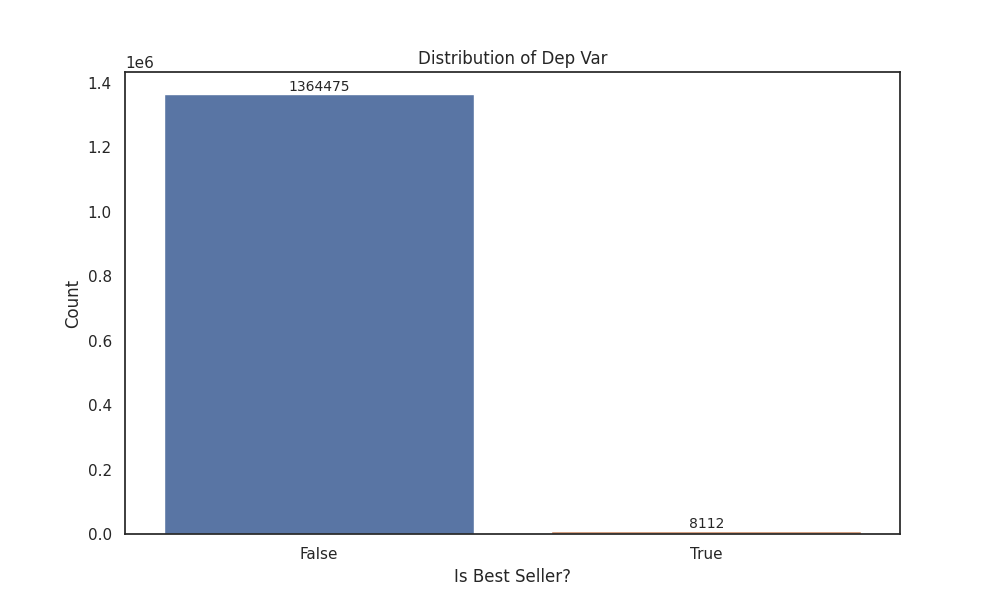

In [23]:
# Visualize distribution of 'isBestSeller' variable

sns.set(style="white")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='isBestSeller', data=products_pd)
plt.title('Distribution of Dep Var')
plt.xlabel('Is Best Seller?')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.show();
%matplot plt

# 3. Examine and Clean Features

### **`stars`**

In [24]:
# Any star rating below 0 or above 5 is also invalid
invalid_stars = products.filter((col('stars') <= 0) | (col('stars') >= 5)).count()
print(invalid_stars)

216452


In [25]:
# Replace invalid entries in 'star' column with Null values
products = products.withColumn('stars', F.when((F.col('stars') <= 0) | (F.col('stars') >= 5), None).otherwise(F.col('stars')))

In [26]:
# We do not find a strict logical cutoff for other features like price, listPrice, category_id or title. Hence, we do not run any transformations on these.

0


# 4. Treating Missing Data

## Data Imputation, Transformation, and Cleaning Strategy

### Dependent Variable (isBestSeller)
- **Decision**: Drop rows where 'isBestSeller' is null.
- **Rationale**: 
  - As the target variable for our classification task, we cannot impute these values without introducing significant bias.
  - Approximately 3.7% of the dependent variable is missing.
  - Given the highly imbalanced nature of our dataset, imputing these values could significantly affect our model's performance and reliability.
  - We treat these missing values as Missing At Random (MAR), considering the web-scraped origin of our data.
- **Implementation**:
  - Remove rows where 'isBestSeller' is null.
  - Note the number of rows removed for transparency in our analysis.

### Stars and Reviews
- **Decision**: No imputation for 'stars' and 'reviews' columns where value is 0.
- **Rationale**: 
  - Zero values in these columns are meaningful, indicating no ratings or reviews.
  - These zeros could be informative for predicting the 'isBestSeller' status.
  - Preserving these zeros maintains the integrity of the original data distribution.

### Price
- **Decision**: Impute prices where value is 0 with the median price.
- **Rationale**:
  - Only 2.3% of price data is zero, limiting the impact on overall distribution.
  - Simplifies subsequent analyses by eliminating special handling for zero prices.
  - Allows use of price in models that can't handle zeros or nulls well.
- **Implementation**:
  - Calculate median price, excluding zeros.
  - Create a flag 'price_imputed' to mark which prices were imputed.
  - Replace zero prices with the median.

### ListPrice
- **Decision**: Convert to a binary feature.
- **Rationale**:
  - 75% of the data has 0 for listPrice, making it more informative as a binary indicator.
  - Simplifies the representation of whether a list price was given or not.
  - Avoids issues with imputing a large portion of the data.
- **Implementation**:
  - Create a new binary column 'has_listPrice'.
  - Set to True when listPrice > 0, False otherwise.

### Considerations for Analysis
- The removal of rows with missing 'isBestSeller' values may slightly reduce our dataset size. The impact of this reduction should be assessed.
- When interpreting results, particularly for price-sensitive analyses, consider the potential impact of price imputation.
- The 'price_imputed' flag allows for separate analysis of imputed values if needed.
- For 'stars' and 'reviews', zero values should be treated as a distinct category in analyses.
- The new binary 'has_listPrice' feature represents the presence or absence of a list price, rather than the price value itself.

This strategy aims to balance data completeness with preservation of original data characteristics, facilitating robust analysis while maintaining transparency about data modifications. By dropping missing values in our dependent variable and carefully handling other features, we ensure the integrity of our classification task while maximizing the use of available data.

In [27]:
# First, let's examine how many missing values does our dataframe contains
total_rows = products.count()
missing_values_percentage = products.select([(sum(col(c).isNull().cast("int")) / total_rows * 100).alias(c) for c in products.columns])
missing_values_percentage.show()

+----+-----+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|asin|title|             stars|           reviews|             price|         listPrice|       category_id|      isBestSeller|boughtInLastMonth|
+----+-----+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
| 0.0|  0.0|18.936548655752464|2.2238082584971153|1.3619502263490326|0.8668358179027817|0.5550581664781885|3.7683941452826364| 1.75491486233618|
+----+-----+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+


In [28]:
# Delete rows where dep var value is Null
products = products.na.drop(subset=['isBestSeller'])

In [30]:
# Impute 'stars' column with median:
median_stars = products.approxQuantile('stars', [0.5], 0)[0]
products = products.na.fill({'stars': median_stars})

In [33]:
# Count number of rows with missing price (i.e., price == 0)
price_missing_count = products.filter(((F.col('price')==0))).count()
(price_missing_count/products.count())*100

2.3411995013795117


In [34]:
# Impute price column with median
median_price = products.approxQuantile("price", [0.5], 0)[0]
products = products.withColumn('price', F.when((F.col('price') == 0), median_price).otherwise(F.col('price')))

In [35]:
# Count number of non-discounted prices i.e., listPrice column with value == 0
listprice_missing_count = products.filter(((F.col('listPrice')==0))).count()
((listprice_missing_count)/products.count())*100

75.69429114511502


In [38]:
# Convert listPrice into a binary variable 'has_listPrice'
# Rationale: Over 75% of listPrice data is 0 (missing or no discount)
# Binary representation:
#   - Preserves information about presence/absence of list price
#   - Avoids imputation issues for a large portion of data
#   - May indicate products with potential discounts or special pricing
products = products.withColumn('has_listPrice', F.when(F.col('listPrice') == 0, 'False').otherwise('True'))

In [41]:
# Revised count of missing values
missing_values_percentage_post_handling = products.select([(sum(col(c).isNull().cast("int")) / total_rows * 100).alias(c) for c in products.columns])
missing_values_percentage_post_handling.show()

+----+-----+-----+-------+-----+---------+-----------+------------+-----------------+-------------+
|asin|title|stars|reviews|price|listPrice|category_id|isBestSeller|boughtInLastMonth|has_listPrice|
+----+-----+-----+-------+-----+---------+-----------+------------+-----------------+-------------+
| 0.0|  0.0|  0.0|    0.0|  0.0|      0.0|        0.0|         0.0|              0.0|          0.0|
+----+-----+-----+-------+-----+---------+-----------+------------+-----------------+-------------+


In [42]:
print("Revised summary post cleaning")
products.describe().show()

Revised summary post cleaning
+-------+--------------------+--------------------+-------------------+------------------+--------------------+------------------+------------------+------------+------------------+-------------+
|summary|                asin|               title|              stars|           reviews|               price|         listPrice|       category_id|isBestSeller| boughtInLastMonth|has_listPrice|
+-------+--------------------+--------------------+-------------------+------------------+--------------------+------------------+------------------+------------+------------------+-------------+
|  count|             1372587|             1372587|            1372587|           1372587|             1372587|           1372587|           1372587|     1372587|           1372587|      1372587|
|   mean|1.8160756785002997E9|3.846153846153846...|  4.378717478596322|183.20376850429153|  42.848201525974645|12.273176126736459|123.76410894172828|        null|143.43152747330407|     

# 4. Save

In [43]:
output_path = "s3://amazon-product-dataset-2024/cleaned/"

In [44]:
products.write.mode("overwrite").format("parquet").option("path", output_path).save()